In [ ]:
# # pip install -U -q tensorflow tensorflow_datasets
# # apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
# from google.colab import files
# import zipfile
# import io

# uploaded = files.upload()
# data = io.BytesIO(uploaded['WingBeatsDS.zip'])
# with zipfile.ZipFile(data, 'r') as zip_ref:
#     zip_ref.extractall('/content')


In [ ]:
# import shutil
# import os
# src = '/content/drive/MyDrive/WingBeatsDS Not Wanted'
# dest = '/content/drive/MyDrive'

# shutil.move(src, dest)

In [ ]:
# for des in dirs:
#   for src in os.listdir(des):
#     cur_src = os.path.join(des, src)
#     if os.path.isdir(cur_src) and not os.listdir(cur_src):
#       os.rmdir(cur_src)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, MaxPooling2D, Conv2D, Resizing
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!unzip /content/drive/MyDrive/WingBeatsDS.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_182644_065_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_182654_066_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_182702_067_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_182703_068_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_182703_069_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_182719_070_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_182807_071_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_182808_072_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_182817_073_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_182829_074_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_182842_075_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_182914_076_G

In [3]:
data_dir = '/content/WingBeatsDS'

In [6]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')


Found 5995 files belonging to 6 classes.
Using 4796 files for training.
Using 1199 files for validation.


In [7]:
label_names = np.array(train_ds.class_names)
label_names

array(['Ae. aegypti', 'Ae. albopictus', 'An. arabiensis', 'An. gambiae',
       'C. pipiens', 'C. quinquefasciatus'], dtype='<U19')

In [8]:
# The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of (batch, samples, channels)
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
# This dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis:


In [9]:
def squeeze(audio, label):
  audio = tf.squeeze(audio, axis = -1)
  return audio, label 
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


In [10]:
# The utils.audio_dataset_from_directory function only returns up to two splits. 
# It's a good idea to keep a test set separate from your validation set. Ideally you'd keep it in a separate directory, 
# but in this case you can use Dataset.shard to split the validation set into two halves. 
# Note that iterating over any shard will load all the data, and only keep its fraction.
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [11]:
label_names[[1,1,3,0]]

array(['Ae. albopictus', 'Ae. albopictus', 'An. gambiae', 'Ae. aegypti'],
      dtype='<U19')

(64, 16000)
(64,)


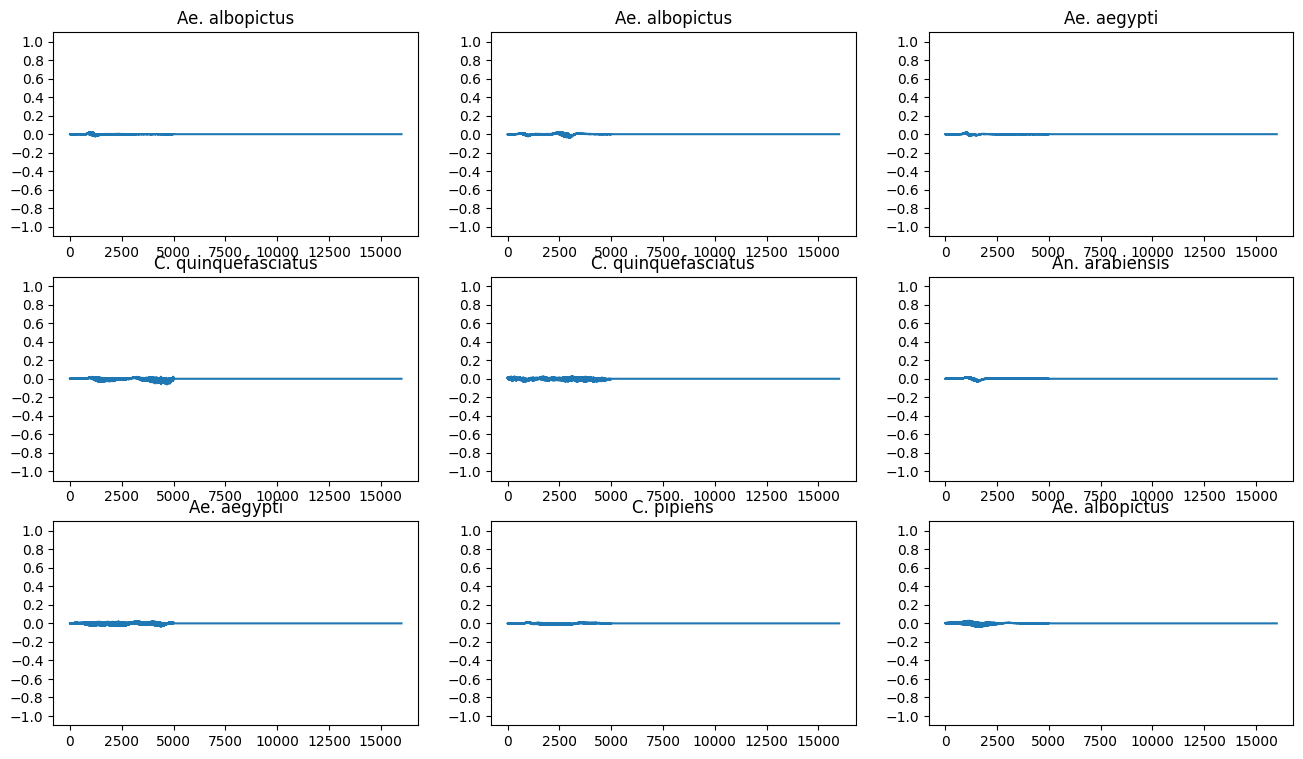

In [12]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)
  rows = 3
  cols = 3
  n = rows * cols
  fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

  for i in range(n):
    if i>=n:
      break
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(example_audio[i].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label_names[example_labels[i]]
    ax.set_title(label)
    ax.set_ylim([-1.1,1.1])

  plt.show()

In [13]:
# Convert waveforms to spectrograms
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram
  

In [14]:
for i in range(6):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: Ae. albopictus
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: Ae. albopictus
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: Ae. aegypti
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: C. quinquefasciatus
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: C. quinquefasciatus
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: An. arabiensis
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)
  

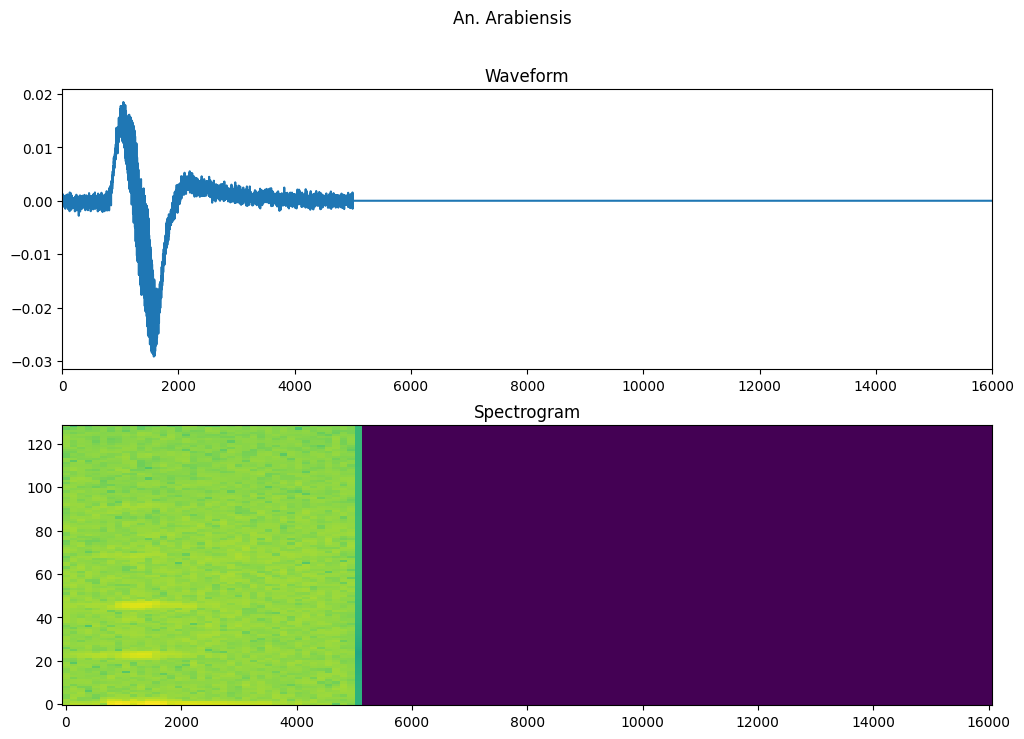

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [17]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)


In [18]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

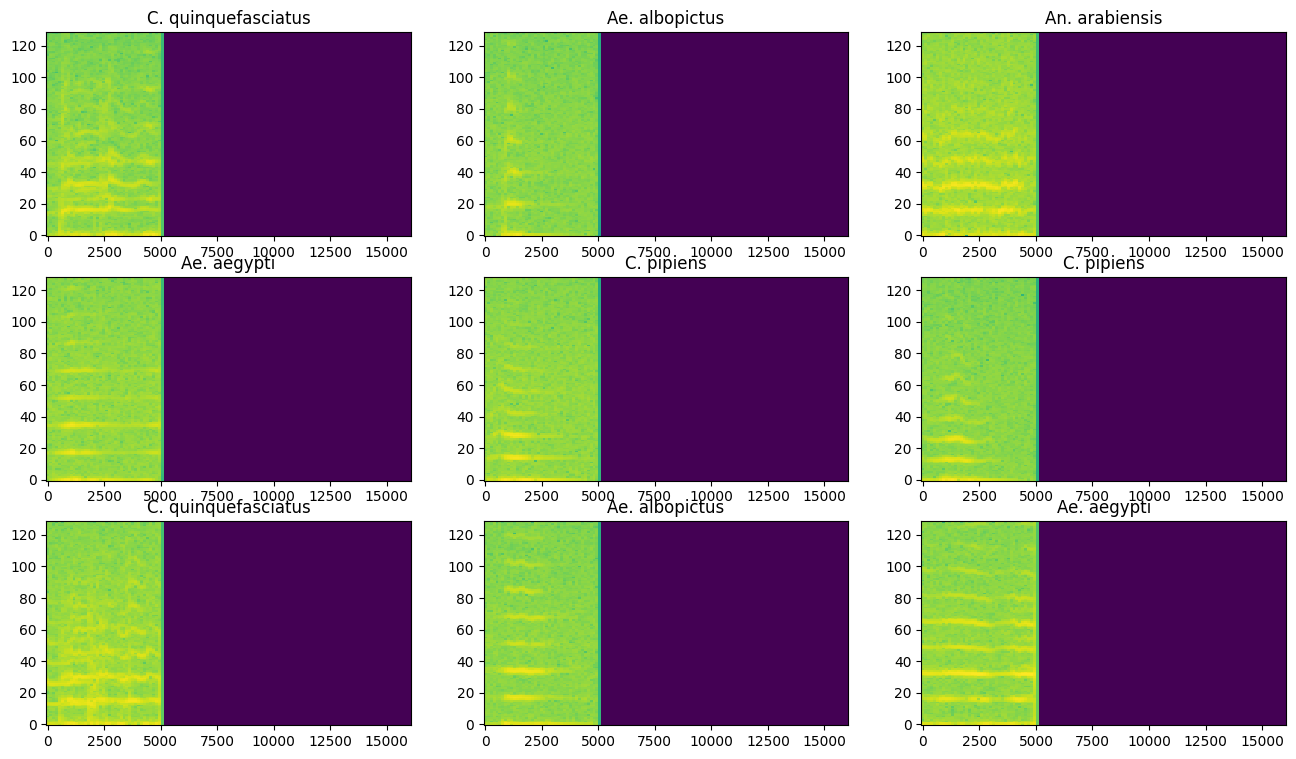

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [20]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# 1st Convolution Layer 2D 16 filters of size 2x2, ReLU
# 1st Max Pooling Layer Pooling Size 2x2
# Dropout Layer Excludes 50% neurons at random
# 2nd Convolution Layer 2D 32 filters of size 2x2, ReLU
# 2nd Max Pooling Layer Pooling size 2x2
# Dropout Layer Excludes 50% neurons at random
# 3rd Convolution Layer 2D 64 filters of size 2x2, ReLU
# 3rd Max Pooling Layer Pooling size 2x2
# Dropout Layer Excludes 50% neurons at random
# 4th Convolution Layer 2D 128 filters of size 2x2, ReLU
# 4th Max Pooling Layer Pooling size 2x2
# Dropout Layer Excludes 50% neurons at random
# Global Average Pooling Layer N/A
# Output Layer three nodes for three classes, SoftMax
# Optimization Function Adam
# Callback ModelCheckpoint


In [28]:


input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    Input(shape=input_shape),
    # Downsample the input.
    Resizing(64, 64),
    # Normalize.
    norm_layer,
    Conv2D(64, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D((2, 2)),
    # Dropout(0.25),

    Conv2D(128, 3, activation='relu'),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D((2, 2)),
    # Dropout(0.25),

    Conv2D(256, 3, activation='relu'),
    Conv2D(256, 3, activation='relu'),
    MaxPooling2D((2, 2)),
    # Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    # Dropout(0.5),
    Dense(num_labels, activation='softmax')
])



model.summary()

# 128 > 64 > 32 rasinate architecture, inseption > optimal filter 3

Input shape: (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 64, 64, 1)         0         
                                                                 
 normalization_1 (Normalizat  (None, 64, 64, 1)        3         
 ion)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)         

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [30]:
EPOCHS = 200
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/200
75/75 [==============================] - 7s 38ms/step - loss: 1.3135 - accuracy: 0.4698 - val_loss: 0.9255 - val_accuracy: 0.6580
Epoch 2/200
75/75 [==============================] - 3s 35ms/step - loss: 0.8072 - accuracy: 0.6935 - val_loss: 0.6935 - val_accuracy: 0.7135
Epoch 3/200
75/75 [==============================] - 3s 37ms/step - loss: 0.6812 - accuracy: 0.7181 - val_loss: 0.6308 - val_accuracy: 0.7500
Epoch 4/200
75/75 [==============================] - 3s 36ms/step - loss: 0.5885 - accuracy: 0.7621 - val_loss: 0.6373 - val_accuracy: 0.7309
Epoch 5/200
75/75 [==============================] - 3s 35ms/step - loss: 0.5442 - accuracy: 0.7713 - val_loss: 0.5550 - val_accuracy: 0.7726
Epoch 6/200
75/75 [==============================] - 3s 35ms/step - loss: 0.5255 - accuracy: 0.7867 - val_loss: 0.5781 - val_accuracy: 0.7656
Epoch 7/200
75/75 [==============================] - 3s 36ms/step - loss: 0.5017 - accuracy: 0.7971 - val_loss: 0.5632 - val_accuracy: 0.7691
Epoch 

Text(0, 0.5, 'Accuracy [%]')

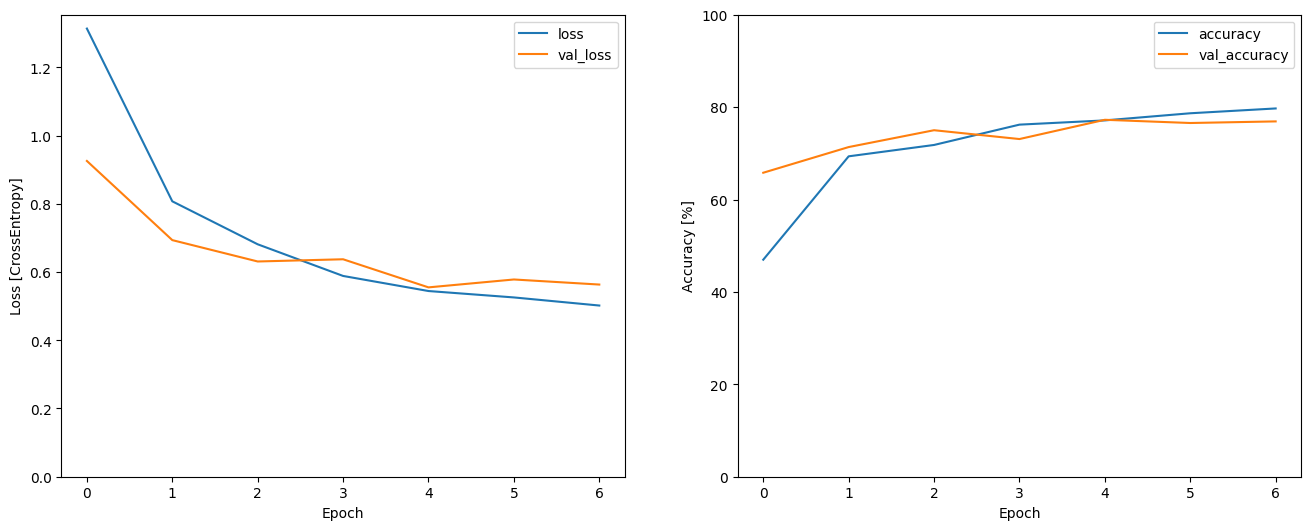

In [31]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [32]:
model.evaluate(test_spectrogram_ds, return_dict=True)

10/10 [==============================] - 0s 16ms/step - loss: 0.5873 - accuracy: 0.7817


{'loss': 0.5873196721076965, 'accuracy': 0.7817014455795288}

In [ ]:
# y_pred = model.predict(test_spectrogram_ds)
# y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
# confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(10, 8))
# sns.heatmap(confusion_mtx,
#             xticklabels=label_names,
#             yticklabels=label_names,
#             annot=True, fmt='g')
# plt.xlabel('Prediction')
# plt.ylabel('Label')
# plt.show()

In [ ]:
# tf.keras.models.save_model(model, '/content/model')
# uploaded_model = tf.keras.models.load_model('/content/model')

In [ ]:
# uploaded_model(tf.constant(str('/content/WingBeatsDS/Ae. aegypti/F161212_194613_156_G_050.wav')))

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)  
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}
  

In [ ]:
export = ExportModel(model)
export(tf.constant(str(data_dir+'/Ae. aegypti/F161212_194613_156_G_050.wav')))

In [ ]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
# imported(waveform[tf.newaxis, :])
